# Part 1: Camera calibration (Intrinsic parameters)

In [2]:
import numpy as np
import cv2
import glob

In [3]:
 # termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [4]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


In [5]:
images = glob.glob('./chessboard patter/*.JPG')


In [6]:
print(images)

['./chessboard patter/IMG_0955.JPG', './chessboard patter/IMG_0954.JPG', './chessboard patter/IMG_0956.JPG', './chessboard patter/IMG_0957.JPG', './chessboard patter/IMG_0953.JPG', './chessboard patter/IMG_0952.JPG', './chessboard patter/IMG_0950.JPG', './chessboard patter/IMG_0951.JPG', './chessboard patter/IMG_0960.JPG', './chessboard patter/IMG_0961.JPG', './chessboard patter/IMG_0963.JPG', './chessboard patter/IMG_0962.JPG', './chessboard patter/IMG_0959.JPG', './chessboard patter/IMG_0958.JPG']


In [10]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners,ret)
        cv2.imwrite('./result/part1/'+str(fname),img)
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [12]:
 ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [13]:
print(ret)


1.0603394007025135


In [14]:
print(mtx)

[[2.34614475e+03 0.00000000e+00 9.53629500e+02]
 [0.00000000e+00 2.34580557e+03 1.33463489e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


# Part 2: Take the pictures

# Part 3: Compute the relative camera pose

In [15]:
from matplotlib import pyplot as plt

img1 = cv2.imread('./Pair image/myleft.JPG',0)  #queryimage # left image
img2 = cv2.imread('./Pair image/myright.JPG',0) #trainimage # right image


In [16]:
cv2.imshow('img1',img1)
cv2.waitKey(500)



-1

In [61]:
import cv2
cv2.__version__

'3.4.4'

In [17]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

Got the list of best matches from both images

In [18]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

In [19]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Now we find the epilines in both the images and draw them.

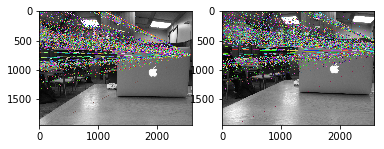

In [20]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()